In [53]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [54]:
import os
import pandas as pd

excel_path = "/content/Results.xlsx"
images_dir = "/content/sem_images"

# 1. Check Excel file and sheets
xls = pd.ExcelFile(excel_path)
print("Sheet names in Excel:")
print(xls.sheet_names)

print("\n---\n")

# 2. Check images folder
#print("Images directory exists?", os.path.exists(images_dir))
print("Files in images_dir:")
print(os.listdir(images_dir))

sheet_to_check = xls.sheet_names[0]  # or "3" or "Bi-0.02" etc

print("Checking sheet:", sheet_to_check)

df_sample = pd.read_excel(excel_path, sheet_name=sheet_to_check)
print("\nColumns in this sheet:")
print(df_sample.columns)

print("\nFirst 5 rows:")
print(df_sample.head())

# Clean column names and check again
df_sample.columns = [str(c).strip() for c in df_sample.columns]
print("\nCleaned column names:")
print(df_sample.columns)

if "Length" in df_sample.columns:
    print("\nMean Length for this sheet:", df_sample["Length"].mean())
else:
    print("\n 'Length' column not found after cleaning.")
print("Testing filename matching logic...\n")

for sheet in xls.sheet_names:
    sample_id = (str(sheet).strip().split("_")[-1])
    print(f"Sheet: '{sheet}'  -> sample_id used for matching: '{sample_id}'")

    # list images that start with that sample_id + "_"
    matched = []
    for fname in os.listdir(images_dir):
        if fname.lower().endswith((".tif", ".tiff", ".png", ".jpg", ".jpeg")):
            if fname.startswith(sample_id + "_"):
                matched.append(fname)

    print("  Matched images:", matched)
    print("  Count:", len(matched))
    print("---")


Sheet names in Excel:
['results_1', 'result_2', 'result_3', 'result_4', 'result_5', 'result_6', 'result_7', 'result_8', 'result_9']

---

Files in images_dir:
['5_002.tif', '8_001.tif', '8_002.tif', '6_004.tif', '6_002.tif', '7_005.tif', '3_002.tif', '1_004.tif', '6_003.tif', '7_003.tif', '4_005.tif', '5_003.tif', '9_003.tif', '5_001.tif', '2_002.tif', '6_001.tif', '2_001.tif', '6_006.tif', '7_001.tif', '6_007.tif', '1_003.tif', '9_001.tif', '1_001.tif', '7_004.tif', '4_001.tif', '6_008.tif', '6_005.tif', '9_002.tif', '4_002.tif', '1_002.tif', '3_003.tif', '4_004.tif', '4_003.tif', '3_001.tif', '5_004.tif', '7_002.tif']
Checking sheet: results_1

Columns in this sheet:
Index([' ', 'Area', 'Mean', 'Min', 'Max', 'Angle', 'Length'], dtype='object')

First 5 rows:
       Area     Mean     Min      Max    Angle  Length
0  1  0.084  109.031  83.894  150.617  107.700   2.852
1  2  0.109  101.872  75.000  155.279   81.995   3.736
2  3  0.072   95.843  66.000  117.514  140.711   2.465
3  4  0.0

In [55]:
rows = []

for sheet in xls.sheet_names:
    # sample_id = number after "result_"
    sample_id = (str(sheet).strip().split("_")[-1])
    print(f"\nProcessing sheet: {sheet} -> sample_id: {sample_id}")

    # read this sheet
    df_sample = pd.read_excel(excel_path, sheet_name=sheet)
    df_sample.columns = [str(c).strip() for c in df_sample.columns]

    # find the length column (maybe "Length", "Length (µm)", etc.)
    length_col = None
    for c in df_sample.columns:
        if "Length" in c:   # loose match
            length_col = c
            break

    if length_col is None:
        print("  No column containing 'Length' found, skipping this sheet.")
        print("  Columns were:", df_sample.columns.tolist())
        continue

    grain_size = df_sample[length_col].mean()
    print(f"  Using column '{length_col}', mean grain size = {grain_size:.3f}")

    matched_count = 0
    for fname in os.listdir(images_dir):
        if fname.lower().endswith((".tif", ".tiff", ".png", ".jpg", ".jpeg")):
            if fname.startswith(sample_id + "_"):
                rows.append({
                    "filename": fname,
                    "sample_id": sample_id,
                    "grain_size": grain_size
                })
                matched_count += 1

    #print(f"  Images matched for sample_id '{sample_id}': {matched_count}")

labels_df = pd.DataFrame(rows)
#print("\nFinal labels_df head:")
#print(labels_df.head())
print("Total labeled images:", len(labels_df))

labels_df.to_csv("/content/sem_labels.csv", index=False)

labels_df = pd.read_csv("/content/sem_labels.csv")
print(labels_df.head())
print("\nUnique sample_ids:", labels_df["sample_id"].unique())
print("\nGrain size stats:")
print(labels_df["grain_size"].describe())




Processing sheet: results_1 -> sample_id: 1
  Using column 'Length', mean grain size = 2.889

Processing sheet: result_2 -> sample_id: 2
  Using column 'Length', mean grain size = 2.103

Processing sheet: result_3 -> sample_id: 3
  Using column 'Length', mean grain size = 1.666

Processing sheet: result_4 -> sample_id: 4
  Using column 'Length', mean grain size = 30.546

Processing sheet: result_5 -> sample_id: 5
  Using column 'Length', mean grain size = 2.052

Processing sheet: result_6 -> sample_id: 6
  Using column 'Length', mean grain size = 2.068

Processing sheet: result_7 -> sample_id: 7
  Using column 'Length', mean grain size = 2.526

Processing sheet: result_8 -> sample_id: 8
  Using column 'Length', mean grain size = 1.301

Processing sheet: result_9 -> sample_id: 9
  Using column 'Length', mean grain size = 1.186
Total labeled images: 36
    filename  sample_id  grain_size
0  1_004.tif          1    2.888642
1  1_003.tif          1    2.888642
2  1_001.tif          1    2

Grain size statistics:
count    36.000000
mean      6.028608
std       9.997283
min       1.185789
25%       2.051610
50%       2.067778
75%       2.617026
max      30.546292
Name: grain_size, dtype: float64


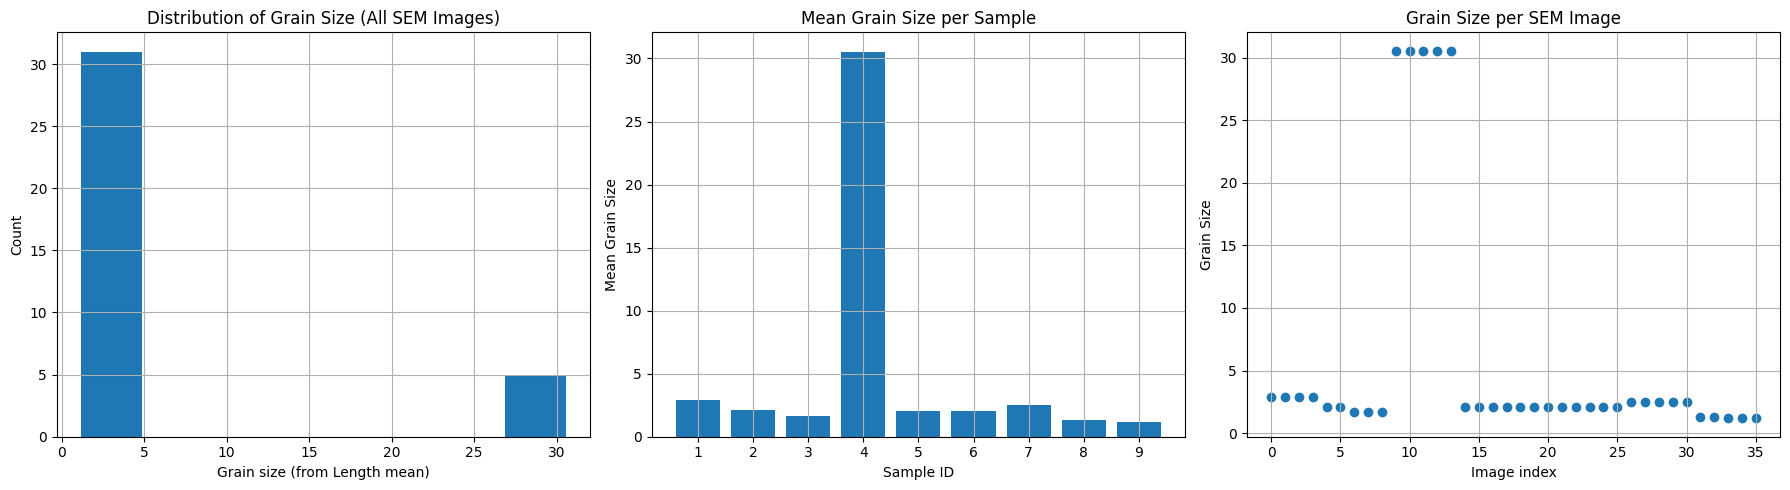

In [56]:
import matplotlib.pyplot as plt
import numpy as np

print("Grain size statistics:")
print(labels_df["grain_size"].describe())

# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5)) # 1 row, 3 columns

# 1) Histogram of grain sizes
axes[0].hist(labels_df["grain_size"], bins=8)
axes[0].set_xlabel("Grain size (from Length mean)")
axes[0].set_ylabel("Count")
axes[0].set_title("Distribution of Grain Size (All SEM Images)")
axes[0].grid(True)

# 2) Bar plot: mean grain size per sample_id
mean_by_sample = labels_df.groupby("sample_id")["grain_size"].mean()
axes[1].bar(mean_by_sample.index.astype(str), mean_by_sample.values)
axes[1].set_xlabel("Sample ID")
axes[1].set_ylabel("Mean Grain Size")
axes[1].set_title("Mean Grain Size per Sample")
axes[1].grid(True)

# 3) Scatter: image index vs grain size (just to see spread)
axes[2].scatter(range(len(labels_df)), labels_df["grain_size"])
axes[2].set_xlabel("Image index")
axes[2].set_ylabel("Grain Size")
axes[2].set_title("Grain Size per SEM Image")
axes[2].grid(True)

plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show()

In [57]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    labels_df,
    test_size=0.35,
    random_state=42,
    shuffle=True   # no stratify for small dataset
)

train_df = train_df.reset_index(drop=True)
val_df   = val_df.reset_index(drop=True)

print("Train size:", len(train_df))
print("Val size  :", len(val_df))

print("\nTrain samples per ID:")
print(train_df["sample_id"].value_counts())

print("\nVal samples per ID:")
print(val_df["sample_id"].value_counts())


Train size: 23
Val size  : 13

Train samples per ID:
sample_id
6    7
1    3
7    3
2    2
5    2
4    2
3    2
9    1
8    1
Name: count, dtype: int64

Val samples per ID:
sample_id
4    3
9    2
7    2
5    2
8    1
6    1
3    1
1    1
Name: count, dtype: int64


In [58]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input

IMG_SIZE = (224, 224)
BATCH_SIZE = 4  # small dataset -> small batch

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    horizontal_flip=True,
    rotation_range=10,
    zoom_range=0.1,
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_gen = train_datagen.flow_from_dataframe(
    train_df,
    directory=images_dir,
    x_col="filename",
    y_col="grain_size",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="raw",  # regression
    shuffle=True
)

val_gen = val_datagen.flow_from_dataframe(
    val_df,
    directory=images_dir,
    x_col="filename",
    y_col="grain_size",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="raw",
    shuffle=False
)


Found 23 validated image filenames.
Found 13 validated image filenames.


In [59]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
import tensorflow as tf

base_model = ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)

# Freeze lower layers, fine-tune upper ~20
for layer in base_model.layers[:-20]:
    layer.trainable = False

inputs = layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation="linear")(x)  # regression for grain size

model = models.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="mse",
    metrics=["mae"]
)

model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 9,193,729 (35.07 MB)

 Non-trainable params: 14,656,384 (55.91 MB)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 981ms/step - loss: 148.8766 - mae: 6.8097

6/6 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - loss: 139.9553 - mae: 6.4747 - val_loss: 225.7797 - val_mae: 8.9479
Epoch 2/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 992ms/step - loss: 36.8851 - mae: 2.2815

6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - loss: 39.1057 - mae: 2.3743 - val_loss: 194.1320 - val_mae: 8.0434
Epoch 3/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 954ms/step - loss: 20.1059 - mae: 2.0620

6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - loss: 24.3965 - mae: 2.2422 - val_loss: 162.8117 - val_mae: 7.3702
Epoch 4/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 12.6742 - mae: 2.0859

6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - loss: 13.8243 - mae: 2.1261 - val_loss: 124.4888 - val_mae: 6.5689
Epoch 5/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 8.3224 - mae: 1.9867

6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - loss: 8.6303 - mae: 2.0204 - val_loss: 71.3425 - val_mae: 5.0984
Epoch 6/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 987ms/step - loss: 12.0201 - mae: 2.4287

6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - loss: 11.6023 - mae: 2.3927 - val_loss: 36.5595 - val_mae: 4.0329
Epoch 7/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - loss: 4.9777 - mae: 1.7841 - val_loss: 41.1082 - val_mae: 4.3848
Epoch 8/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - loss: 6.8042 - mae: 1.5121 - val_loss: 50.0071 - val_mae: 4.5746
Epoch 9/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - loss: 3.6063 - mae: 1.7355 - val_loss: 62.3145 - val_mae: 4.6013
Epoch 10/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - loss: 1.7402 - mae: 1.0222 - val_loss: 62.6727 - val_mae: 4.6210
Epoch 11/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - loss: 2.9700 - mae: 1.4847 - val_loss: 50.5616 - val_mae: 4.1822


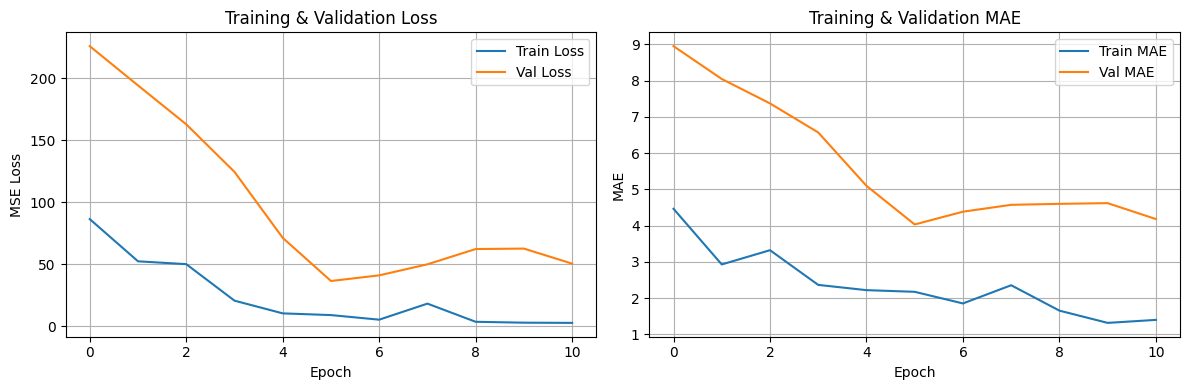

In [60]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True
    ),
    ModelCheckpoint(
        "best_resnet50_grainsize.h5",
        monitor="val_loss",
        save_best_only=True
    )
]

EPOCHS = 25

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks
)

# Plot training curves
history_df = pd.DataFrame(history.history)

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 4)) # 1 row, 2 columns

# Plot Training & Validation Loss
axes[0].plot(history_df["loss"], label="Train Loss")
axes[0].plot(history_df["val_loss"], label="Val Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("MSE Loss")
axes[0].set_title("Training & Validation Loss")
axes[0].legend()
axes[0].grid(True)

# Plot Training & Validation MAE
axes[1].plot(history_df["mae"], label="Train MAE")
axes[1].plot(history_df["val_mae"], label="Val MAE")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("MAE")
axes[1].set_title("Training & Validation MAE")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step
MSE: 36.560
MAE: 4.033
R² : 0.749


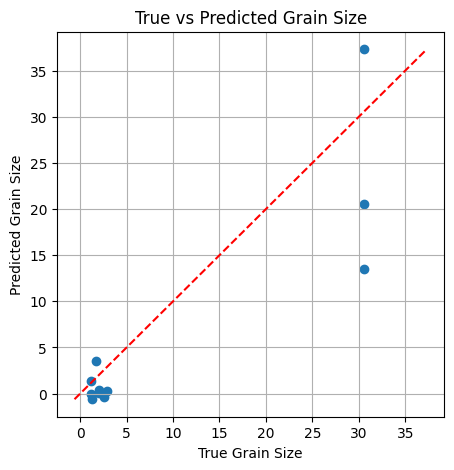

In [61]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

val_preds = model.predict(val_gen).flatten()
val_true  = val_df["grain_size"].values

mse = mean_squared_error(val_true, val_preds)
mae = mean_absolute_error(val_true, val_preds)
r2  = r2_score(val_true, val_preds)

print(f"MSE: {mse:.3f}")
print(f"MAE: {mae:.3f}")
print(f"R² : {r2:.3f}")

# True vs Predicted scatter
plt.figure(figsize=(5, 5))
plt.scatter(val_true, val_preds)
min_v = min(val_true.min(), val_preds.min())
max_v = max(val_true.max(), val_preds.max())
plt.plot([min_v, max_v], [min_v, max_v], "r--")
plt.xlabel("True Grain Size")
plt.ylabel("Predicted Grain Size")
plt.title("True vs Predicted Grain Size")
plt.grid(True)
plt.show()


In [84]:
from tensorflow.keras.preprocessing import image

test_row = val_df.iloc[0]   # We have to change the value here to selct an image

test_path = os.path.join(images_dir, test_row["filename"])

print("Image:", test_row["filename"])
print("True grain size:", test_row["grain_size"])

img = image.load_img(test_path, target_size=IMG_SIZE)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

pred_gs = model.predict(x)[0][0]
print("Predicted grain size:", pred_gs)


Image: 9_002.tif
True grain size: 1.1857885304659497
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
Predicted grain size: 1.3276033
